In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.efficientnet import preprocess_input, EfficientNetB7
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import cv2
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import time

In [2]:
def crop_center_square(img):
    # 이미지의 크기를 가져옵니다.
    min_dim = min(img.size)
    # 중앙에서 정사각형으로 자르기 위한 시작점을 계산합니다.
    start_x = (img.size[0] - min_dim) // 2
    start_y = (img.size[1] - min_dim) // 2
    # 이미지를 자릅니다.
    return img.crop((start_x, start_y, start_x + min_dim, start_y + min_dim))

In [3]:
def build_feature_extractor():
    model = EfficientNetB7(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(600, 600, 3),
    )
    model.trainable = False
    
    image_input = keras.Input((600, 600, 3))
    image_features = model(image_input)
    output = Dense(10, activation="softmax")(image_features)

    return Model(inputs=image_input, outputs=output, name="feature_extractor_efficientnet")

In [4]:
train_dir = 'data/train'
# 비디오 파일 목록과 태그를 포함하는 리스트를 만드는 함수
def create_data_list(data_dir):
    data_list = []
    for item in os.listdir(data_dir):
        item_path = os.path.join(data_dir, item)
        if os.path.isdir(item_path):
            for file_name in os.listdir(item_path):
                if file_name.endswith('.jpg'):
                    data_list.append((item, str(data_dir+'/'+item)+'/'+file_name))
    return data_list

train_list = create_data_list(train_dir)
train_df = pd.DataFrame(data=train_list, columns=['tag', 'image_name'])
train_df

,tag,image_name
0,belly,data/train/belly/20231206_121209_001.jpg
1,belly,data/train/belly/20231206_121209_002.jpg
2,belly,data/train/belly/20231206_121209_003.jpg
3,belly,data/train/belly/20231206_121209_004.jpg
4,belly,data/train/belly/20231206_121209_005.jpg
...,...,...
1662,where,data/train/where/20231206_115431_012.jpg
1663,where,data/train/where/20231206_115431_013.jpg
1664,where,data/train/where/20231206_115431_014.jpg
1665,where,data/train/where/20231206_115431_015.jpg


In [5]:
# CSV 파일로 저장
csv_filename = 'image_data.csv'
train_df.to_csv(csv_filename, index=False)

# CSV 파일 불러오기
df = pd.read_csv('image_data.csv')

# 이미지 데이터와 레이블을 저장할 리스트
image_data = []
labels = []

In [6]:
for index, row in df.iterrows():
    img = Image.open(row['image_name'])
    img = crop_center_square(img)
    img = img.resize((600, 600))   # EfficientNetB7에 적합한 크기로 조정
    img_array = image.img_to_array(img)
    img_array = preprocess_input(img_array)  # 이미지 전처리
    image_data.append(img_array)
    labels.append(row['tag'])

# 넘파이 배열로 변환
image_data = np.array(image_data)
labels = np.array(labels)

KeyboardInterrupt: 

In [6]:
# 이미지 데이터와 레이블을 압축된 npz 파일로 저장
np.savez_compressed('image_data.npz', image_data=image_data, labels=labels)

In [6]:
# 저장된 npz 파일 로드
data = np.load('image_data.npz')

# 데이터를 다시 넘파이 배열로 추출
image_data = data['image_data']
labels = data['labels']

In [7]:
model = build_feature_extractor()

# 모델 컴파일
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [8]:
# 먼저 데이터를 셔플링
indices = np.arange(len(image_data))
np.random.shuffle(indices)
image_data = image_data[indices]
labels = labels[indices]

In [9]:
# 레이블 인코더 생성
label_encoder = LabelEncoder()
integer_encoded_labels = label_encoder.fit_transform(labels)

In [10]:
# 정수 라벨을 원-핫 인코딩으로 변환
labels_one_hot = to_categorical(integer_encoded_labels, num_classes=10)

In [11]:
# stratify를 사용하여 데이터를 분할
image_data_train, image_data_val, labels_train, labels_val = train_test_split(
    image_data, labels_one_hot, test_size=0.2, stratify=labels)

In [12]:
datagen = ImageDataGenerator()

In [14]:
# batch_size = 16  # 예를 들어, 배치 크기를 16으로 줄임
# 학습 데이터 생성기
train_generator = datagen.flow(x=image_data_train, y=labels_train,batch_size=batch_size)
# 검증 데이터 생성기
validation_generator = datagen.flow(x=image_data_val, y=labels_val, batch_size=batch_size)

# 콜백 정의
checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# 모델 학습
# 모델 학습
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10
84/84 [==============================] - ETA: 0s - loss: 0.5206 - accuracy: 0.9602 

C:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


84/84 [==============================] - 1076s 13s/step - loss: 0.5206 - accuracy: 0.9602 - val_loss: 0.2346 - val_accuracy: 0.9940
Epoch 2/10
84/84 [==============================] - 1063s 13s/step - loss: 0.2117 - accuracy: 0.9932 - val_loss: 0.1152 - val_accuracy: 1.0000
Epoch 3/10
84/84 [==============================] - 1060s 13s/step - loss: 0.1184 - accuracy: 0.9992 - val_loss: 0.0721 - val_accuracy: 1.0000
Epoch 4/10
84/84 [==============================] - 1059s 13s/step - loss: 0.0853 - accuracy: 0.9992 - val_loss: 0.0478 - val_accuracy: 1.0000
Epoch 5/10
84/84 [==============================] - 1059s 13s/step - loss: 0.0570 - accuracy: 1.0000 - val_loss: 0.0346 - val_accuracy: 1.0000
Epoch 6/10
84/84 [==============================] - 1059s 13s/step - loss: 0.0466 - accuracy: 1.0000 - val_loss: 0.0273 - val_accuracy: 1.0000
Epoch 7/10
84/84 [==============================] - 1059s 13s/step - loss: 0.0376 - accuracy: 1.0000 - val_loss: 0.0214 - val_accuracy: 1.0000
Epoch 8/10

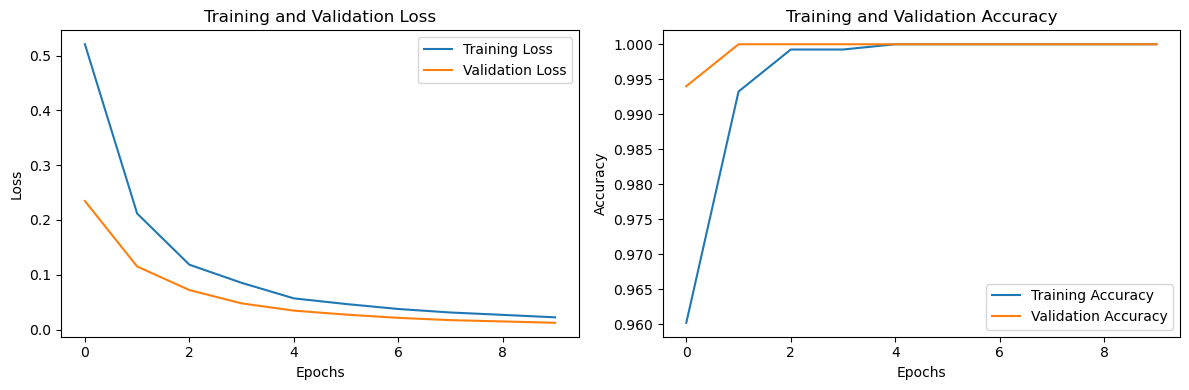

In [17]:
# 손실 그래프
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# 정확도 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
model.save('efficientnet_model.h5')

C:\Users\SMHRD\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [4]:
# 모델불러오기
from tensorflow.keras.models import load_model
restored_model = load_model('efficientnet_model.h5')

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe4 in position 21: invalid continuation byte

In [20]:
# 예측 수행
predictions = model.predict(image_data_val)
predicted_classes = np.argmax(predictions, axis=1)

# 예측된 정수 라벨을 문자열 라벨로 변환
predicted_labels = label_encoder.inverse_transform(predicted_classes)

11/11 [==============================] - 214s 19s/step


In [44]:
# 이미지를 불러오고 크기 조정
image = Image.open('data/train/lost/20231206_115104_041.jpg')
image = crop_center_square(image)
image = image.resize((600,600))
image = img_to_array(image)
image = preprocess_input(image)

# 배치 차원 추가
image = np.expand_dims(image, axis=0)

# 예측 수행
predictions = model.predict(image)
predicted_class = np.argmax(predictions, axis=1)

# 예측된 정수 라벨을 문자열 라벨로 변환
predicted_label = label_encoder.inverse_transform(predicted_class)

1/1 [==============================] - 1s 505ms/step


In [45]:
predicted_label

array(['lost'], dtype='<U6')

In [49]:
def crop_center_square_frame(frame):
    h, w = frame.shape[:2]
    min_dim = min(h, w)
    start_x = (w - min_dim) // 2
    start_y = (h - min_dim) // 2
    return frame[start_y:start_y+min_dim, start_x:start_x+min_dim]

In [59]:
prediction_interval = 5
next_prediction_time = time.time() + prediction_interval

# 예측된 라벨을 저장하기 위한 변수 초기화
predicted_label = ""

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, img = cap.read()
    if not ret:
        print("프레임을 읽을 수 없습니다.")
        break

    # 현재 시간이 다음 예측 시간을 넘었는지 확인
    if time.time() >= next_prediction_time:
        # 예측을 위한 전처리 수행
        image = crop_center_square_frame(img)
        image = cv2.resize(image, (600, 600))
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)
        
        # 예측 수행
        predictions = model.predict(image)
        predicted_class = np.argmax(predictions, axis=1)
        predicted_label = label_encoder.inverse_transform(predicted_class)[0]
        
        # 다음 예측 시간 업데이트
        next_prediction_time = time.time() + prediction_interval

    # 예측된 라벨을 화면에 표시 (예측이 수행된 이후로 계속)
    if predicted_label:
        cv2.putText(img, predicted_label, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 0), 2)

    # 화면에 프레임 표시
    cv2.imshow('Webcam Live Prediction', img)

    # 'q'를 누르면 종료
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# 작업 완료 후 해제
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 1s 536ms/step


KeyboardInterrupt: 